# HHM - Referente

## Cargando librerias de trabajo

In [ ]:
#!pip install pyclustering




     ---------------------------------------- 0.0/2.6 MB ? eta -:--:--
     ---------------------------------------- 2.6/2.6 MB 24.6 MB/s eta 0:00:00
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Created wheel for pyclustering: filename=pyclustering-0.10.1.2-py3-none-any.whl size=2395230 sha256=5376cdc236d6c9287717221c9162344c8439cafb54203a1977f83128b96f6307
  Stored in directory: c:\users\diego\appdata\local\pip\cache\wheels\9f\99\15\e881f46a92690ae77c2e3b255b89ea45d3a867b1b6c2ab3ba9
Successfully built pyclustering



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from pathlib import Path
from sklearn.cluster import KMeans
from scipy.stats import skew
from sklearn.preprocessing import MinMaxScaler
import plotly.express as px
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import plotly.express as px
import plotly.io as pio
from pyclustering.cluster.kmedoids import kmedoids
from pyclustering.cluster import cluster_visualizer_multidim
from pyclustering.utils.metric import distance_metric, type_metric

In [2]:
# Ruta absoluta al archivo CSV
csv_path = Path(r"e:\Maestría_Eafit2024\Maestria\Trabajo de grado\DataLab2\archive\data-science-project\data\stage\df_var_obs.csv")

# Leer el CSV directamente
df_XDB = pd.read_csv(csv_path, encoding="utf-8-sig")

# Mostrar primeras filas
df_XDB.head()


,Smoking,Family History of Anxiety,Stress Level,Diet Quality,Anxiety Level,Therapy Sessions (per month),Sleep Hours,Physical Activity (hrs/week),Caffeine Intake (mg/day),Heart Rate (bpm)
0,False,True,0.000000,0.000000,0.4,1.000000,0.50,0.2,0.320534,0.966102
1,False,False,1.000000,0.222222,0.6,0.666667,1.00,0.6,0.612688,0.898305
2,False,False,1.000000,0.555556,1.0,0.111111,0.50,0.0,0.220367,0.322034
3,False,False,0.333333,1.000000,0.2,0.555556,0.50,0.2,0.602671,0.152542
4,False,False,0.222222,0.333333,0.6,0.666667,0.75,0.4,0.886477,0.084746


## Creacion de la columna tiempo y el ID

In [3]:

# Define cuántos pasos quieres por sujeto (mínimo 2)
T = 2
n = len(df_XDB)
n_ids = max(1, n // T)

# Asigna IDs ciclando (1,1,1,2,2,2,3,3,3,...) y baraja si quieres
ids = np.repeat(np.arange(1, n_ids+1), T)[:n]
np.random.seed(42)
np.random.shuffle(ids)

df_XDB_ID = df_XDB.copy()
df_XDB_ID['ID'] = ids

# Crea una fecha simulada por ID con saltos aleatorios (tu estrategia 2)
df_XDB_ID = df_XDB_ID.sort_values('ID').reset_index(drop=True)
df_XDB_ID['fecha'] = (
    pd.to_datetime("2022-01-01") 
    + pd.to_timedelta(
        df_XDB_ID.groupby('ID').cumcount().values * 30  # ~mensual
        + np.random.randint(0, 15, size=len(df_XDB_ID)), # irregularidad
        unit='D'
    )
)

# Orden final y 'time'
df_XDB_ID = df_XDB_ID.sort_values(['ID','fecha']).reset_index(drop=True)
df_XDB_ID['time'] = df_XDB_ID.groupby('ID').cumcount() + 1

In [4]:
df_XDB_ID.head(10)

,Smoking,Family History of Anxiety,Stress Level,Diet Quality,Anxiety Level,Therapy Sessions (per month),Sleep Hours,Physical Activity (hrs/week),Caffeine Intake (mg/day),Heart Rate (bpm),ID,fecha,time
0,False,True,0.888889,0.111111,0.4,0.000000,0.25,0.6,0.293823,0.728814,1,2022-01-03,1
1,False,False,0.111111,0.777778,0.4,0.444444,0.50,0.8,0.779633,0.118644,1,2022-01-31,2
2,True,False,1.000000,0.000000,1.0,1.000000,0.00,0.0,0.816361,0.627119,2,2022-01-08,1
3,False,False,0.666667,0.000000,1.0,0.888889,0.25,0.0,0.218698,0.610169,2,2022-02-12,2
4,False,False,1.000000,0.333333,1.0,0.888889,1.00,0.6,0.984975,0.711864,3,2022-01-13,1
5,True,False,0.555556,0.555556,0.6,0.333333,0.75,0.2,0.420701,0.694915,3,2022-02-09,2
6,False,False,0.555556,0.333333,0.8,0.333333,0.75,0.8,0.026711,0.847458,4,2022-01-14,1
7,True,False,0.000000,0.333333,0.0,0.000000,0.75,1.0,0.330551,0.677966,4,2022-02-10,2
8,False,False,0.000000,0.111111,0.2,0.333333,0.50,0.2,0.824708,0.542373,5,2022-01-15,1
9,True,False,0.111111,0.333333,0.2,0.111111,0.00,0.4,0.871452,0.016949,5,2022-02-10,2


## Procesamiento de datos

In [5]:
# Orden temporal por ID y fecha (si tienes múltiples individuos/series)
# Ajusta el parseo de 'fecha' según formato si es necesario:
df_XDB_ID["fecha"] = pd.to_datetime(df_XDB_ID["fecha"], errors="coerce")
df_XDB_ID = df_XDB_ID.sort_values(["ID", "fecha", "time"], na_position="last").reset_index(drop=True)




# VARIABLE NO OBSERVABLE (Y_d)
# ------------------------------
# Tomamos Anxiety Level como *proxy* de la variable latente y la convertimos a [0,1]
y_cont = df_XDB_ID["Anxiety Level"].astype(float).values.reshape(-1, 1)
y_cont = MinMaxScaler().fit_transform(y_cont)   # 0=sano ... 1=peor (ya no invertimos)



In [6]:
df_XDB_ID.head()

,Smoking,Family History of Anxiety,Stress Level,Diet Quality,Anxiety Level,Therapy Sessions (per month),Sleep Hours,Physical Activity (hrs/week),Caffeine Intake (mg/day),Heart Rate (bpm),ID,fecha,time
0,False,True,0.888889,0.111111,0.4,0.000000,0.25,0.6,0.293823,0.728814,1,2022-01-03,1
1,False,False,0.111111,0.777778,0.4,0.444444,0.50,0.8,0.779633,0.118644,1,2022-01-31,2
2,True,False,1.000000,0.000000,1.0,1.000000,0.00,0.0,0.816361,0.627119,2,2022-01-08,1
3,False,False,0.666667,0.000000,1.0,0.888889,0.25,0.0,0.218698,0.610169,2,2022-02-12,2
4,False,False,1.000000,0.333333,1.0,0.888889,1.00,0.6,0.984975,0.711864,3,2022-01-13,1


In [7]:
display(y_cont)

array([[0.4],
       [0.4],
       [1. ],
       ...,
       [0.6],
       [1. ],
       [0.8]], shape=(22000, 1))

## Modelación - Variable observable

Se procede con la construcción de la matriz de transición del riesgo para la variable no observable - Anxiety Level

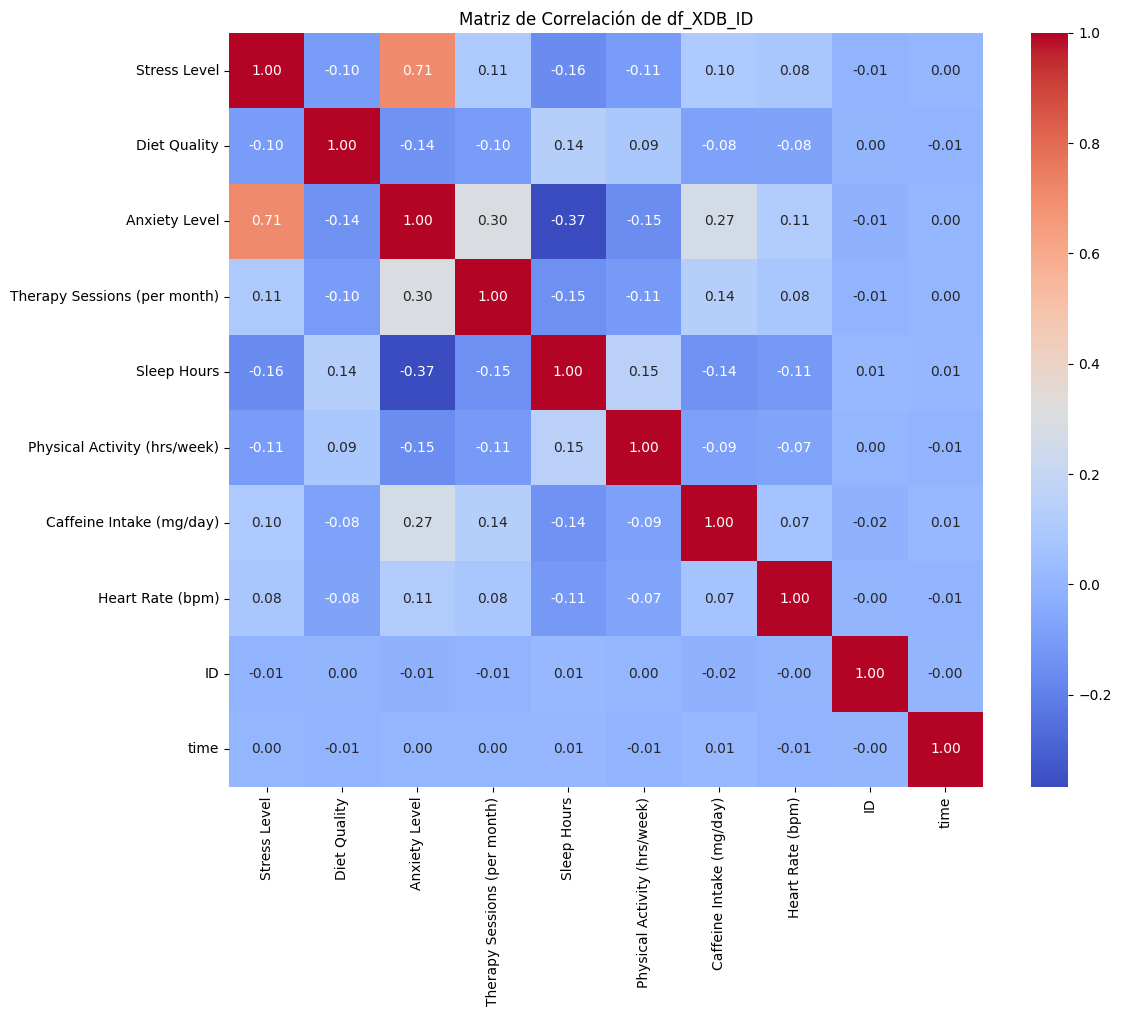

In [8]:

# Selecciona solo las columnas numéricas para la matriz de correlación
corr = df_XDB_ID.select_dtypes(include=['number']).corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Matriz de Correlación de df_XDB_ID")
plt.tight_layout()
plt.show()

In [9]:
cols = [
    'Smoking', 'Stress Level',
    'Therapy Sessions (per month)', 'Sleep Hours', 'Anxiety Level',
    'Physical Activity (hrs/week)'
]

# Filtra solo las columnas que existen en df_XDB_ID
cols_exist = [col for col in cols if col in df_XDB_ID.columns]
df_selected  = df_XDB_ID[cols_exist].copy()

df_selected.head()

,Smoking,Stress Level,Therapy Sessions (per month),Sleep Hours,Anxiety Level,Physical Activity (hrs/week)
0,False,0.888889,0.000000,0.25,0.4,0.6
1,False,0.111111,0.444444,0.50,0.4,0.8
2,True,1.000000,1.000000,0.00,1.0,0.0
3,False,0.666667,0.888889,0.25,1.0,0.0
4,False,1.000000,0.888889,1.00,1.0,0.6


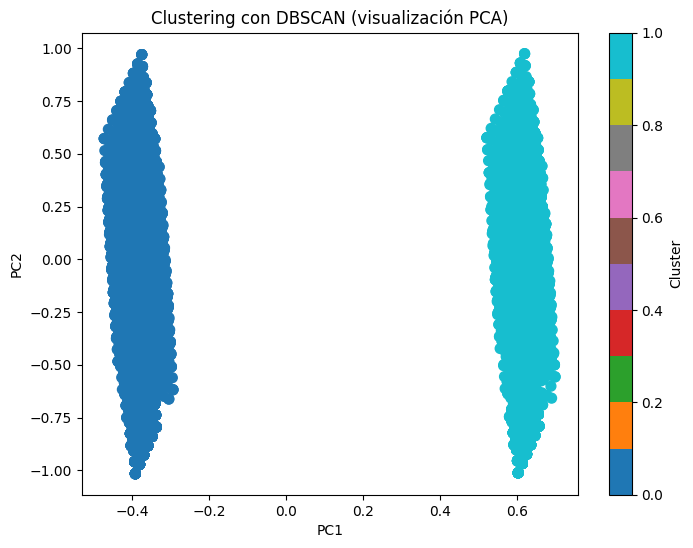

Cluster_DBSCAN
0    13732
1     8268
Name: count, dtype: int64


In [10]:

# Clustering con DBSCAN

# 2. Definir variables observables (excluimos la no observable: Anxiety Level)
observables = df_selected.drop(columns=["Anxiety Level"])

# 3. Aplicar DBSCAN (ajusta eps y min_samples según resultados)
dbscan = DBSCAN(eps=0.8, min_samples=10)  
clusters = dbscan.fit_predict(observables)

# Guardar resultado en el dataframe
df_selected["Cluster_DBSCAN"] = clusters

# 5. Visualización con PCA a 2D
pca = PCA(n_components=4)
X_pca = pca.fit_transform(observables)

plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=clusters, cmap="tab10", s=50)
plt.title("Clustering con DBSCAN (visualización PCA)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar(label="Cluster")
plt.show()

# Ver distribución de clusters
print(df_selected["Cluster_DBSCAN"].value_counts())


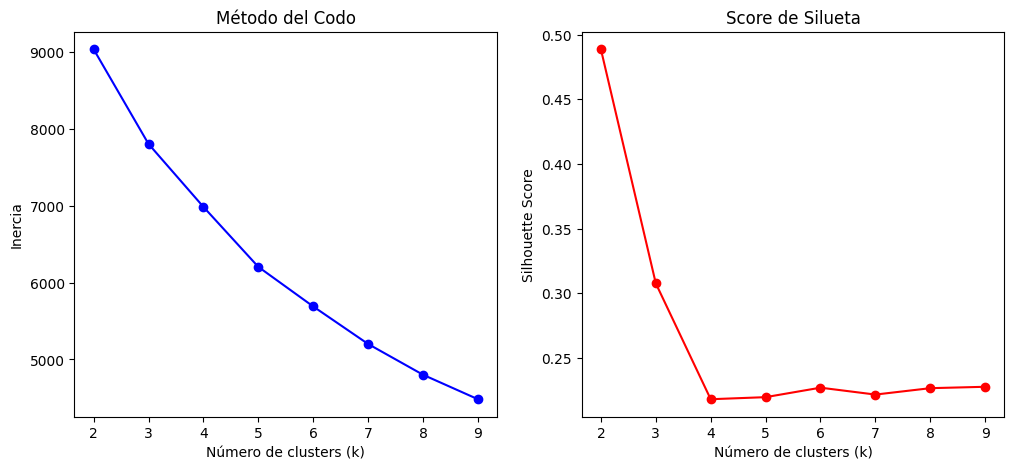

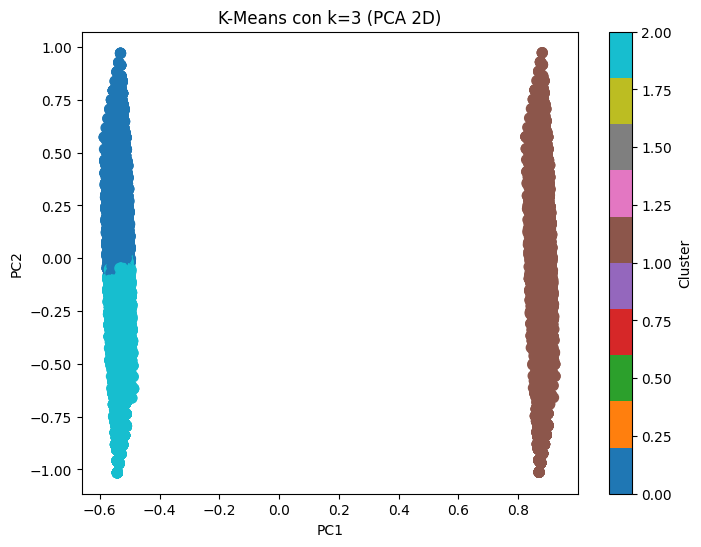

Cluster_KMeans
1    8268
0    7886
2    5846
Name: count, dtype: int64
                Smoking  Stress Level  Therapy Sessions (per month)  \
Cluster_KMeans                                                        
0                   0.0      0.390087                      0.336024   
1                   1.0      0.542547                      0.355386   
2                   0.0      0.727107                      0.530904   

                Sleep Hours  Physical Activity (hrs/week)  Cluster_DBSCAN  
Cluster_KMeans                                                             
0                  0.671728                      0.620365             0.0  
1                  0.516993                      0.455298             1.0  
2                  0.378079                      0.260794             0.0  


In [11]:


# 1. Cargar dataset
# 2. Seleccionar variables observables
observables = df_selected.drop(columns=["Anxiety Level"])

# 3. Método del codo para elegir k
inertia = []
silhouette = []
K_range = range(2, 10)  # probar entre 2 y 9 clusters

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(observables)
    inertia.append(kmeans.inertia_)
    silhouette.append(silhouette_score(observables, kmeans.labels_))

# Graficar método del codo
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(K_range, inertia, 'bo-')
plt.xlabel('Número de clusters (k)')
plt.ylabel('Inercia')
plt.title('Método del Codo')

plt.subplot(1,2,2)
plt.plot(K_range, silhouette, 'ro-')
plt.xlabel('Número de clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Score de Silueta')

plt.show()

# 4. Ajustar modelo con el k óptimo (ejemplo k=3)
k_optimo = 3
kmeans = KMeans(n_clusters=k_optimo, random_state=42, n_init=10)
df_selected["Cluster_KMeans"] = kmeans.fit_predict(observables)

# 5. Visualización con PCA (2D)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(observables)

plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=df_selected["Cluster_KMeans"], cmap="tab10", s=50)
plt.title(f"K-Means con k={k_optimo} (PCA 2D)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar(label="Cluster")
plt.show()

# 6. Ver distribución y promedios por cluster
print(df_selected["Cluster_KMeans"].value_counts())
print(df_selected.groupby("Cluster_KMeans")[observables.columns].mean())


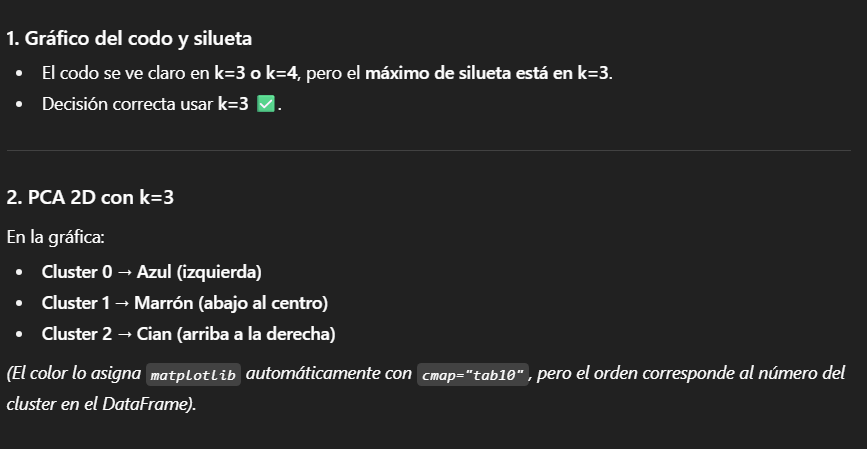

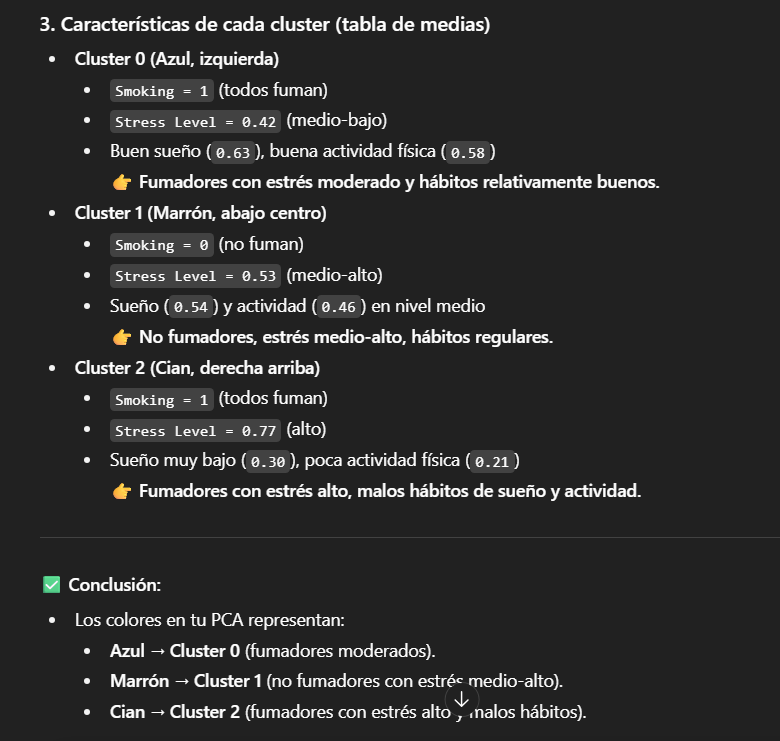

In [13]:


# ==========================
# 1. Configurar renderizador
# ==========================
pio.renderers.default = "browser"   # abrirá el gráfico en tu navegador por defecto

# ==========================
# 2. Cargar dataset

# ==========================
# 3. Variables observables (quitamos Anxiety Level)
# ==========================
observables = df_selected.drop(columns=["Anxiety Level"])

# ==========================
# 4. Ajustar K-Means con k=3
# ==========================
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
df_selected["Cluster_KMeans"] = kmeans.fit_predict(observables)

# ==========================
# 5. Reducir a 3D con PCA
# ==========================
pca = PCA(n_components=3)
X3 = pca.fit_transform(observables)

df_selected["PC1"] = X3[:,0]
df_selected["PC2"] = X3[:,1]
df_selected["PC3"] = X3[:,2]

# ==========================
# 6. Visualización 3D interactiva con Plotly
# ==========================
fig = px.scatter_3d(
    df_selected, x="PC1", y="PC2", z="PC3",
    color=df_selected["Cluster_KMeans"].astype(str),  # clusters como categorías
    symbol=df_selected["Cluster_KMeans"].astype(str),
    hover_data=["Stress Level", "Sleep Hours", "Physical Activity (hrs/week)", "Smoking"],
    title="Clusters K-Means en 3D (PCA)",
    opacity=0.7
)

fig.show()

# Guardar el gráfico en un archivo HTML
fig.write_html("clusters_kmeans_3d.html", include_plotlyjs="cdn", auto_open=True)


In [ ]:



X = df_selected.drop(columns=["Anxiety Level"]).values

# inicialización: elige índices aleatorios como medoides iniciales
k = 3
np.random.seed(42)
initial_medoids = np.random.choice(len(X), size=k, replace=False).tolist()

# métrica euclídea (puedes cambiar a manhattan si quieres)
metric = distance_metric(type_metric.MANHATTAN)

kmed = kmedoids(X, initial_medoids, metric=metric)
kmed.process()
labels = np.zeros(len(X), dtype=int)
for i, cluster in enumerate(kmed.get_clusters()):
    labels[cluster] = i

df_selected["Cluster_KMedoids"] = labels
print(df_selected["Cluster_KMedoids"].value_counts())
print(df_selected.groupby("Cluster_KMedoids").mean(numeric_only=True))


Cluster_KMedoids
2    8268
0    7886
1    5846
Name: count, dtype: int64
                  Smoking  Stress Level  Therapy Sessions (per month)  \
Cluster_KMedoids                                                        
0                     0.0      0.390087                      0.336024   
1                     0.0      0.727107                      0.530904   
2                     1.0      0.542547                      0.355386   

                  Sleep Hours  Anxiety Level  Physical Activity (hrs/week)  \
Cluster_KMedoids                                                             
0                    0.671728       0.414887                      0.620365   
1                    0.378079       0.726103                      0.260794   
2                    0.516993       0.551669                      0.455298   

                  Cluster_DBSCAN  Cluster_KMeans       PC1       PC2       PC3  
Cluster_KMedoids                                                                
0       

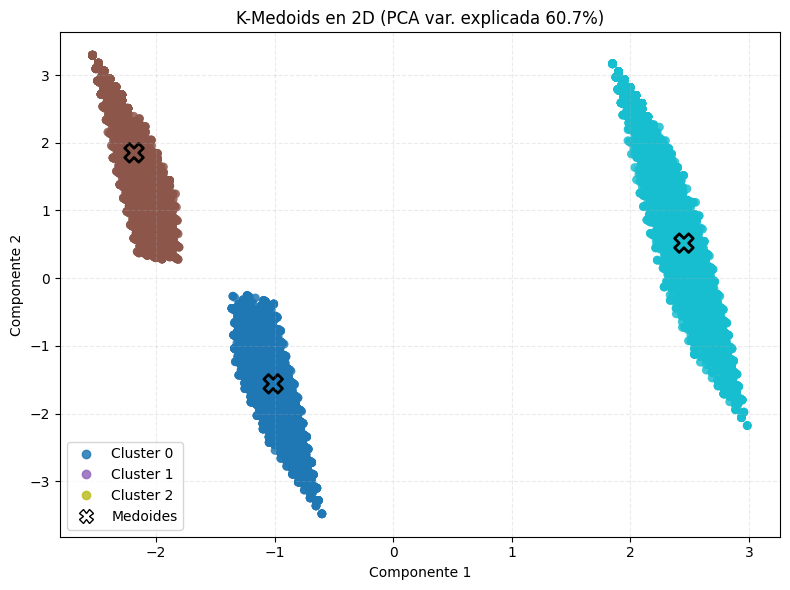

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Asumo que ya tienes X, kmed, labels
use_pca = X.shape[1] > 2
if use_pca:
    scaler = StandardScaler()
    Xs = scaler.fit_transform(X)
    pca = PCA(n_components=2, random_state=42)
    Z = pca.fit_transform(Xs)
    medoid_idx = kmed.get_medoids()
    medoids_2d = pca.transform(scaler.transform(X[medoid_idx]))
    title = f"K-Medoids en 2D (PCA var. explicada {pca.explained_variance_ratio_.sum():.1%})"
else:
    Z = X
    medoid_idx = kmed.get_medoids()
    medoids_2d = X[medoid_idx]
    title = "K-Medoids en 2D (features originales)"

plt.figure(figsize=(8, 6))
scatter = plt.scatter(Z[:, 0], Z[:, 1], c=labels, cmap="tab10", alpha=0.85, s=40, edgecolors="none")
plt.scatter(medoids_2d[:, 0], medoids_2d[:, 1],
            marker="X", s=180, linewidths=2,
            facecolors="none", edgecolors="black", label="Medoides")

# ← Aquí el fix
handles, _ = scatter.legend_elements(prop="colors", alpha=0.85,
                                     num=len(np.unique(labels)))
cluster_labels = [f"Cluster {i}" for i in np.unique(labels)]

plt.legend(handles + [plt.Line2D([0], [0], marker="X", linestyle="", markersize=10,
                                 markeredgecolor="black", markerfacecolor="none")],
           cluster_labels + ["Medoides"],
           loc="best", frameon=True)

plt.title(title)
plt.xlabel("Componente 1" if use_pca else "X1")
plt.ylabel("Componente 2" if use_pca else "X2")
plt.grid(True, linestyle="--", alpha=0.25)
plt.tight_layout()
plt.show()


In [19]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import plotly.express as px
import plotly.graph_objects as go

# --- Asumo que ya tienes estos objetos de tu K-Medoids previo ---
# X = df_selected.drop(columns=["Anxiety Level"]).values
# kmed.process()
# labels = ...  (array de clusters)

# 1) PCA a 3D y proyección consistente para puntos y medoides
scaler = StandardScaler()
Xs = scaler.fit_transform(X)

pca = PCA(n_components=3, random_state=42)
Z = pca.fit_transform(Xs)

medoid_idx = kmed.get_medoids()
medoids_3d = pca.transform(scaler.transform(X[medoid_idx]))

var_exp = pca.explained_variance_ratio_.sum()

# 2) DataFrame para Plotly
plot_df = pd.DataFrame(Z, columns=["Comp1", "Comp2", "Comp3"])
plot_df["Cluster"] = labels.astype(int).astype(str)
plot_df["Index"] = np.arange(len(plot_df))

# 3) Dispersión 3D por cluster
fig = px.scatter_3d(
    plot_df,
    x="Comp1", y="Comp2", z="Comp3",
    color="Cluster",
    hover_data=["Index"],
    opacity=0.9,
    title=f"K-Medoids en 3D • PCA var. explicada: {var_exp:.1%}"
)

# 4) Añadir medoides (símbolo X)
fig.add_trace(
    go.Scatter3d(
        x=medoids_3d[:, 0], y=medoids_3d[:, 1], z=medoids_3d[:, 2],
        mode="markers",
        name="Medoides",
        marker=dict(symbol="x", size=10, line=dict(width=3)),
        hovertemplate="Medoide<br>PC1=%{x:.3f}<br>PC2=%{y:.3f}<br>PC3=%{z:.3f}<extra></extra>"
    )
)

# 5) Estética
fig.update_layout(
    legend_title_text="Cluster",
    scene=dict(
        xaxis_title="Componente 1",
        yaxis_title="Componente 2",
        zaxis_title="Componente 3",
    ),
    template="plotly"
)

fig.show()

# 6) Guardar a HTML
fig.write_html("kmedoids_3d.html", include_plotlyjs="cdn")
print("Gráfico 3D guardado en kmedoids_3d.html")


Gráfico 3D guardado en kmedoids_3d.html


## Modelación - Variables observables

Se hace el mismo proceso de clusterización con las variables observables.

In [16]:
XP=np.array(df_XDB_ID.iloc[:,2])

mkm=KMeans(n_clusters=5)  #Cuál es el mejor modelo de clusterización?
mkm.fit(XP.reshape(-1,1))
XCp=mkm.cluster_centers_
XCp=np.array(sorted(XCp))

#Debemos clasificar los niveles de precipitación por clusters.
NRp=np.zeros((len(XP)))   #Cuál es la mejor estrategía de aprendizaje para un modelo de este tipo?
for k in range(len(XP)):
  dist=np.abs(XCp-XP[k,])
  NRp[k,]=np.argmin(dist)
  print(k,XP[k,],NRp[k,])

0 0.8888888888888888 3.0
1 0.1111111111111111 0.0
2 1.0 4.0
3 0.6666666666666665 2.0
4 1.0 4.0
5 0.5555555555555556 2.0
6 0.5555555555555556 2.0
7 0.0 0.0
8 0.0 0.0
9 0.1111111111111111 0.0
10 0.7777777777777777 3.0
11 0.1111111111111111 0.0
12 0.1111111111111111 0.0
13 0.6666666666666665 2.0
14 0.4444444444444445 1.0
15 0.3333333333333333 1.0
16 0.5555555555555556 2.0
17 0.1111111111111111 0.0
18 0.0 0.0
19 0.4444444444444445 1.0
20 0.7777777777777777 3.0
21 0.8888888888888888 3.0
22 0.0 0.0
23 0.1111111111111111 0.0
24 0.5555555555555556 2.0
25 0.3333333333333333 1.0
26 1.0 4.0
27 0.6666666666666665 2.0
28 0.0 0.0
29 0.4444444444444445 1.0
30 0.0 0.0
31 0.1111111111111111 0.0
32 0.7777777777777777 3.0
33 0.7777777777777777 3.0
34 0.7777777777777777 3.0
35 1.0 4.0
36 0.1111111111111111 0.0
37 0.7777777777777777 3.0
38 0.7777777777777777 3.0
39 0.7777777777777777 3.0
40 0.1111111111111111 0.0
41 0.8888888888888888 3.0
42 0.2222222222222222 1.0
43 0.8888888888888888 3.0
44 0.66666666666

Se procede con la construcción de la matriz de emisión. Es la matriz que muestra la relación entre la variable no observable (Anxiety Level) y la variable observable (Stress level).

In [ ]:
MEp=np.zeros((5,5))   #¿Porque cinco categorias de riesgo? - Curva Codo

for k in range(len(XP)-1):
  nc=int(NRp[k,])   #Niveles de Riesgo - Anxiety Level- No Observable
  nf=int(NRo[k,])   #Niveles de Riesgo - Stress Level - Observable
  #print(nf)
  MEp[nf,nc]+=1

print("Matriz de Emisión para nivel de ansiedad:\n",MEp)
MEPp=MEp/np.sum(MEp,axis=1).reshape(-1,1)

print("Matriz de Emisión para la nivel de ansiedad porcentual:\n",MEPp)

Matriz de Emisión para nivel de ansiedad:
 [[2546. 1961.  473.  127.   18.]
 [1038. 1962.  989.  553.  143.]
 [ 377. 1419. 1389. 1241.  457.]
 [  69.  470.  888. 1238.  779.]
 [   5.   84.  292. 2136. 1345.]]
Matriz de Emisión para la nivel de ansiedad porcentual:
 [[0.49678049 0.38263415 0.09229268 0.02478049 0.0035122 ]
 [0.22155816 0.41878335 0.21109925 0.11803629 0.03052295]
 [0.07720664 0.29060004 0.28445628 0.25414704 0.09359001]
 [0.02003484 0.13646922 0.25783972 0.35946574 0.22619048]
 [0.00129467 0.02175039 0.07560849 0.55308131 0.34826515]]


### Creacion del vector de distribución inicial de estados (pi)

In [20]:
VRo=np.sum(MTr,axis=1)   #Este vector tiene que ser sobre los datos de construcción del modelo
VRop=VRo/np.sum(VRo)
print("La estructura porcentual del riesgo es:",VRop)

La estructura porcentual del riesgo es: [0.23296513 0.21296423 0.22196463 0.15655257 0.17555343]
